In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
import plotly.express as px
import matplotlib.pyplot as plt

import catboost as cat
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

sns.set_style("whitegrid")

In [2]:
hpp = pd.read_csv("data_adv_pred.csv")

In [3]:
hpp.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [4]:
hpp['date'] = pd.to_datetime(hpp['date'])

In [5]:
hpp["month"] = hpp['date'].dt.month.astype('category')
hpp["waterfront"] = hpp["waterfront"].astype('category')
hpp['view'] = hpp['view'].astype('category')
hpp['city'] = hpp['city'].astype('category')

In [6]:
hpp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           4600 non-null   datetime64[ns]
 1   price          4600 non-null   float64       
 2   bedrooms       4600 non-null   float64       
 3   bathrooms      4600 non-null   float64       
 4   sqft_living    4600 non-null   int64         
 5   sqft_lot       4600 non-null   int64         
 6   floors         4600 non-null   float64       
 7   waterfront     4600 non-null   category      
 8   view           4600 non-null   category      
 9   condition      4600 non-null   int64         
 10  sqft_above     4600 non-null   int64         
 11  sqft_basement  4600 non-null   int64         
 12  yr_built       4600 non-null   int64         
 13  yr_renovated   4600 non-null   int64         
 14  street         4600 non-null   object        
 15  city           4600 n

In [7]:
hpp.drop("country",inplace=True,axis=1)

In [8]:
hpp.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,sqft_above,sqft_basement,yr_built,yr_renovated
count,4.600000e+03,4600.000000,4600.000000,4600.000000,4.600000e+03,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000
mean,5.519630e+05,3.400870,2.160815,2139.346957,1.485252e+04,1.512065,3.451739,1827.265435,312.081522,1970.786304,808.608261
std,5.638347e+05,0.908848,0.783781,963.206916,3.588444e+04,0.538288,0.677230,862.168977,464.137228,29.731848,979.414536
min,0.000000e+00,0.000000,0.000000,370.000000,6.380000e+02,1.000000,1.000000,370.000000,0.000000,1900.000000,0.000000
25%,3.228750e+05,3.000000,1.750000,1460.000000,5.000750e+03,1.000000,3.000000,1190.000000,0.000000,1951.000000,0.000000
50%,4.609435e+05,3.000000,2.250000,1980.000000,7.683000e+03,1.500000,3.000000,1590.000000,0.000000,1976.000000,0.000000
75%,6.549625e+05,4.000000,2.500000,2620.000000,1.100125e+04,2.000000,4.000000,2300.000000,610.000000,1997.000000,1999.000000
max,2.659000e+07,9.000000,8.000000,13540.000000,1.074218e+06,3.500000,5.000000,9410.000000,4820.000000,2014.000000,2014.000000


In [9]:
hpp.corr()['price'].sort_values(ascending=False).head(6)

price            1.000000
sqft_living      0.430410
sqft_above       0.367570
bathrooms        0.327110
sqft_basement    0.210427
bedrooms         0.200336
Name: price, dtype: float64

In [10]:
hpp.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,sqft_above,sqft_basement,yr_built,yr_renovated
price,1.000000,0.200336,0.327110,0.430410,0.050451,0.151461,0.034915,0.367570,0.210427,0.021857,-0.028774
bedrooms,0.200336,1.000000,0.545920,0.594884,0.068819,0.177895,0.025080,0.484705,0.334165,0.142461,-0.061082
bathrooms,0.327110,0.545920,1.000000,0.761154,0.107837,0.486428,-0.119994,0.689918,0.298020,0.463498,-0.215886
sqft_living,0.430410,0.594884,0.761154,1.000000,0.210538,0.344850,-0.062826,0.876443,0.447206,0.287775,-0.122817
sqft_lot,0.050451,0.068819,0.107837,0.210538,1.000000,0.003750,0.000558,0.216455,0.034842,0.050706,-0.022730
floors,0.151461,0.177895,0.486428,0.344850,0.003750,1.000000,-0.275013,0.522814,-0.255510,0.467481,-0.233996
condition,0.034915,0.025080,-0.119994,-0.062826,0.000558,-0.275013,1.000000,-0.178196,0.200632,-0.399698,-0.186818
sqft_above,0.367570,0.484705,0.689918,0.876443,0.216455,0.522814,-0.178196,1.000000,-0.038723,0.408535,-0.160426
sqft_basement,0.210427,0.334165,0.298020,0.447206,0.034842,-0.255510,0.200632,-0.038723,1.000000,-0.161675,0.043125
yr_built,0.021857,0.142461,0.463498,0.287775,0.050706,0.467481,-0.399698,0.408535,-0.161675,1.000000,-0.321342


<AxesSubplot:>

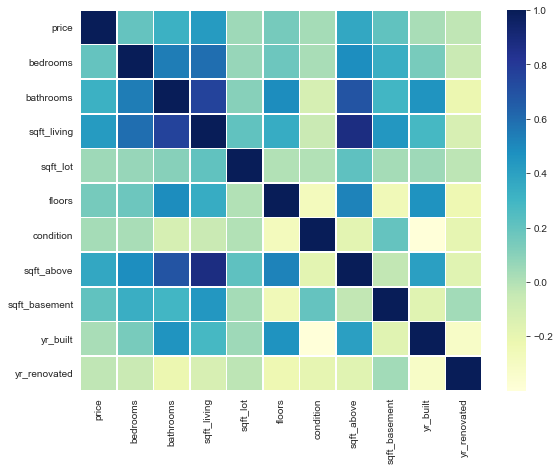

In [11]:
fig, ax = pyplot.subplots(figsize=(9,7))
sns.heatmap(hpp.corr(),ax=ax,linewidths=.5,cmap="YlGnBu")

In [12]:
#sns.pairplot(hpp,diag_kind='kde')
#plt.show()


### None of  the feature seems to have high correlation. maximum is sqft_living     (0.430)

## Univariate Analysis

In [13]:
hpp_numerical = hpp._get_numeric_data()

In [14]:
hpp_numerical.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,sqft_above,sqft_basement,yr_built,yr_renovated
0,313000.0,3.0,1.50,1340,7912,1.5,3,1340,0,1955,2005
1,2384000.0,5.0,2.50,3650,9050,2.0,5,3370,280,1921,0
2,342000.0,3.0,2.00,1930,11947,1.0,4,1930,0,1966,0
3,420000.0,3.0,2.25,2000,8030,1.0,4,1000,1000,1963,0
4,550000.0,4.0,2.50,1940,10500,1.0,4,1140,800,1976,1992


In [15]:
hpp_numerical.shape

(4600, 11)

In [16]:
hpp_numerical.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated'],
      dtype='object')

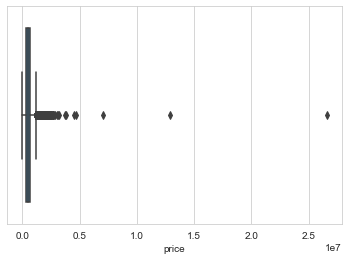

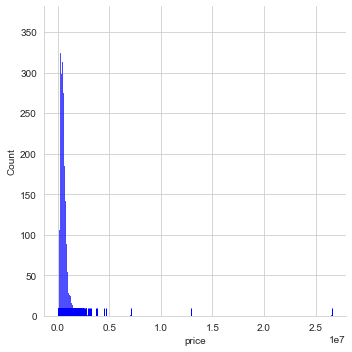

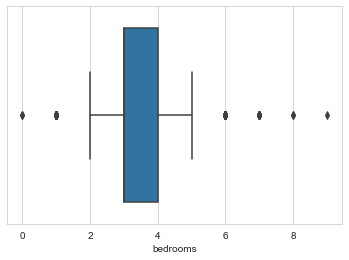

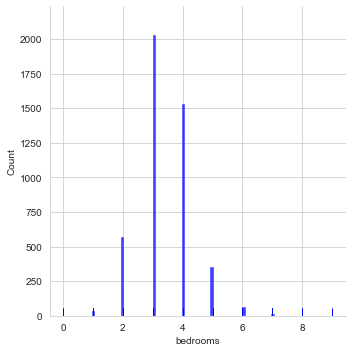

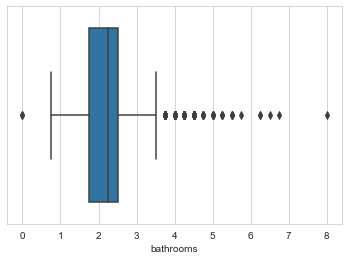

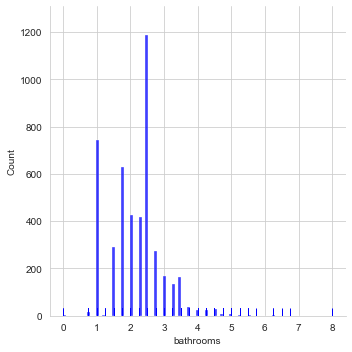

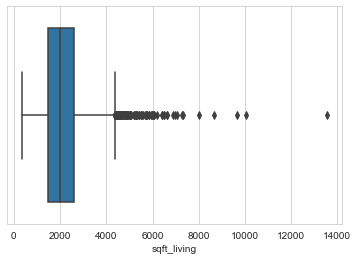

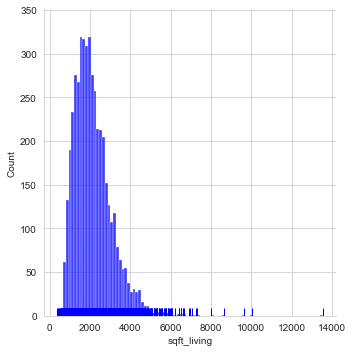

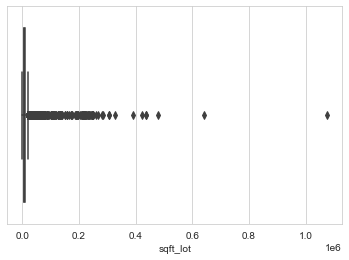

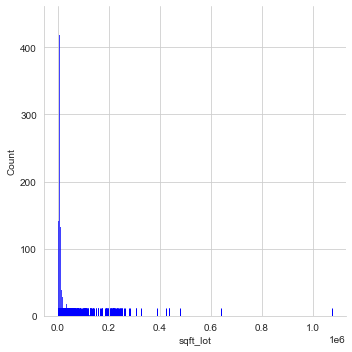

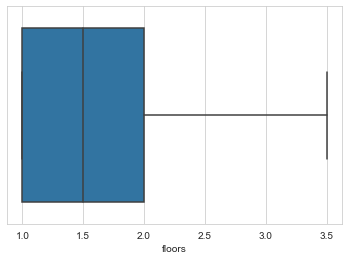

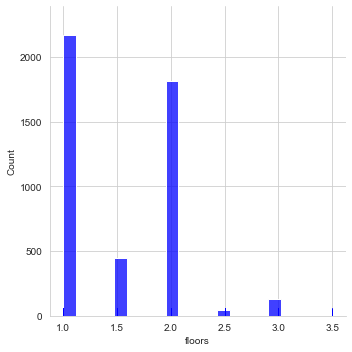

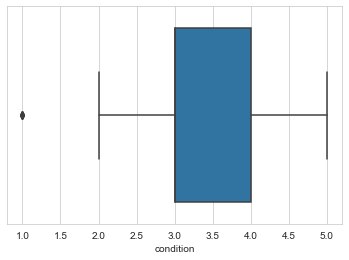

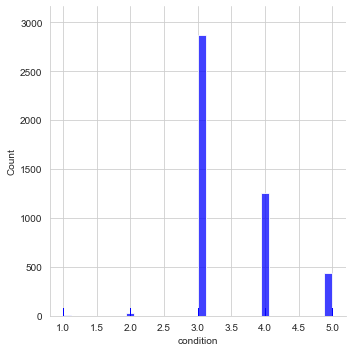

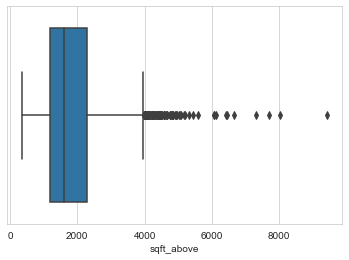

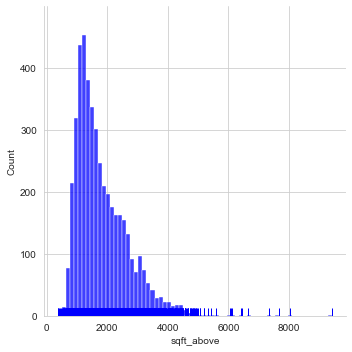

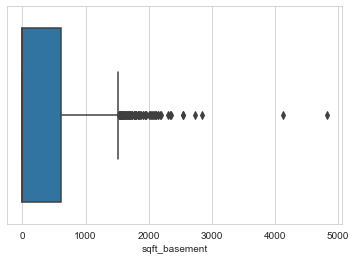

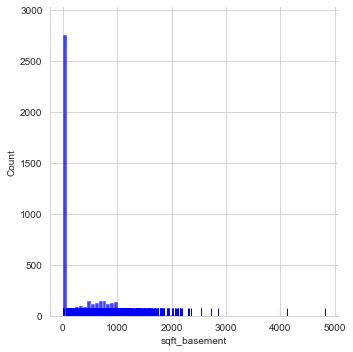

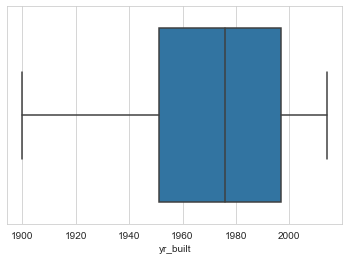

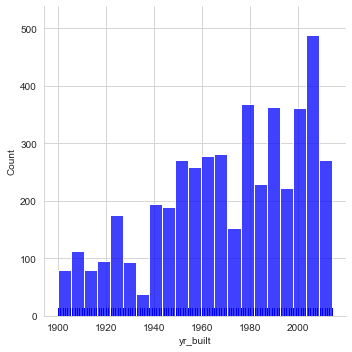

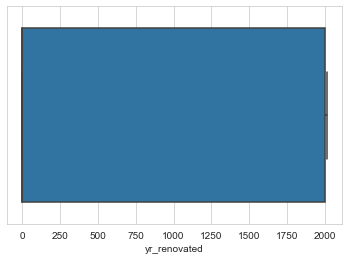

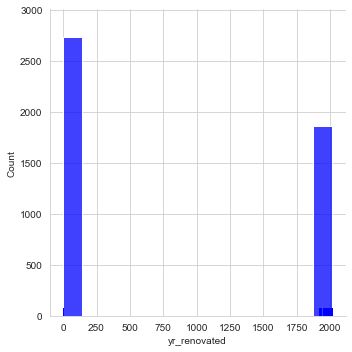

In [17]:
for column in hpp_numerical.columns:
    sns.boxplot(x=column,data=hpp_numerical)
    plt.show()
    
    sns.displot(hpp[column],color='Blue',rug=True)
    plt.show()

In [18]:
for column in hpp_numerical.columns:
    
    #using IQR
    iqr = np.percentile(hpp_numerical[column],75) - np.percentile(hpp_numerical[column],25)
    ll = np.percentile(hpp_numerical[column],25) - (1.5 * iqr)
    ul = np.percentile(hpp_numerical[column],75) + (1.5 * iqr)
    
    #using 3 STD Technique
    #ul = np.mean(hpp_numerical[column]) + (3*np.std(hpp_numerical[column]))
    #ll = np.mean(hpp_numerical[column]) - (3*np.std(hpp_numerical[column]))
    
    print(column)
    print(ll,ul)
    print(hpp_numerical[(hpp_numerical[column]>ul) | (hpp_numerical[column]<ll) ][column].count())
    #print(hpp_numerical[(hpp_numerical[column]>hpp_price_ul) | (hpp_numerical[column]<hpp_price_ll) ].index)
    
    
    hpp_numerical.drop(hpp_numerical[(hpp_numerical[column]>ul) | (hpp_numerical[column]<ll)].index,inplace=True)

price
-175256.25 1153093.75
240
bedrooms
1.5 5.5
100
bathrooms
0.625 3.625
66
sqft_living
-105.0 4015.0
57
sqft_lot
-3076.0 18460.0
460
floors
-0.5 3.5
0
condition
1.5 5.5
3
sqft_above
-160.625 3334.375
74
sqft_basement
-825.0 1375.0
39
yr_built
1877.0 2069.0
0
yr_renovated
-2998.5 4997.5
0


In [19]:
hpp_numerical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3561 entries, 0 to 4599
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          3561 non-null   float64
 1   bedrooms       3561 non-null   float64
 2   bathrooms      3561 non-null   float64
 3   sqft_living    3561 non-null   int64  
 4   sqft_lot       3561 non-null   int64  
 5   floors         3561 non-null   float64
 6   condition      3561 non-null   int64  
 7   sqft_above     3561 non-null   int64  
 8   sqft_basement  3561 non-null   int64  
 9   yr_built       3561 non-null   int64  
 10  yr_renovated   3561 non-null   int64  
dtypes: float64(4), int64(7)
memory usage: 462.9 KB


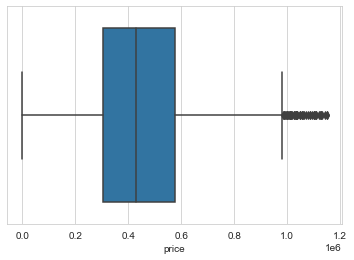

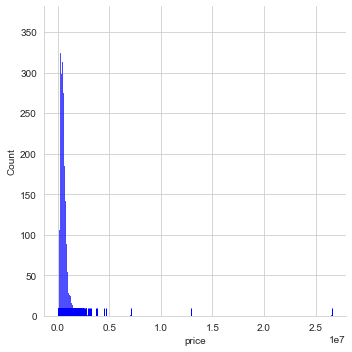

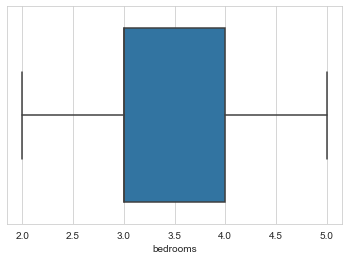

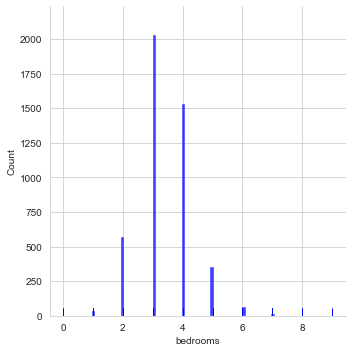

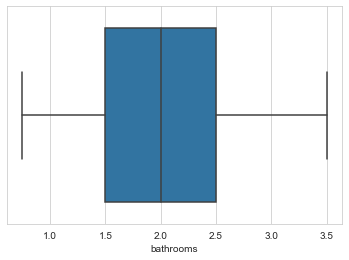

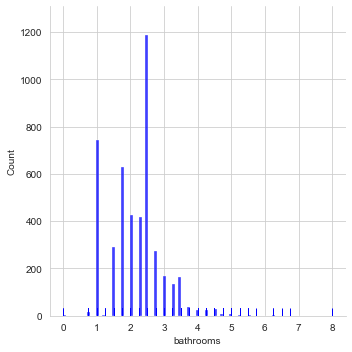

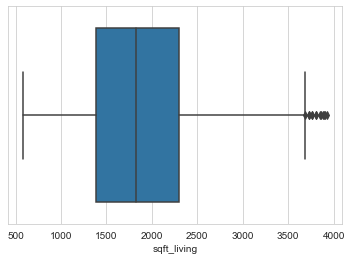

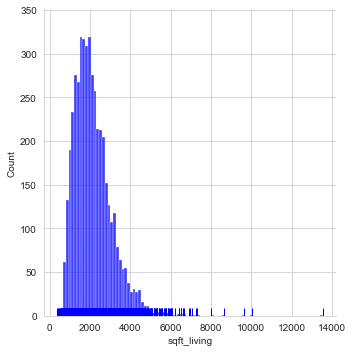

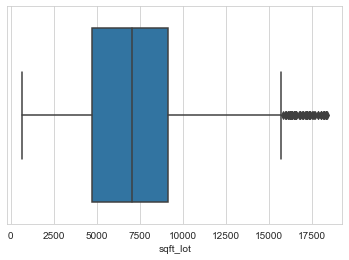

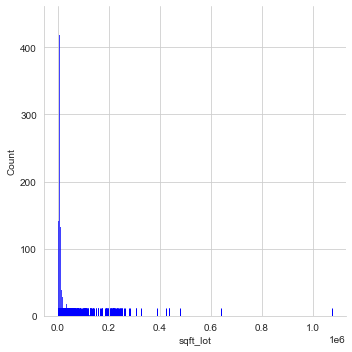

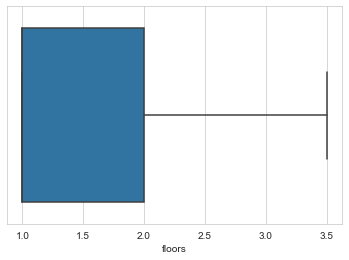

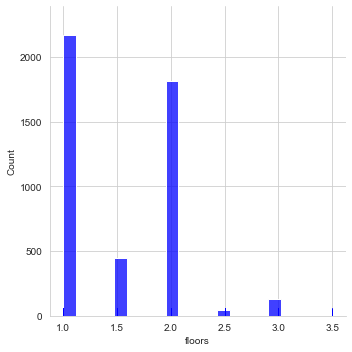

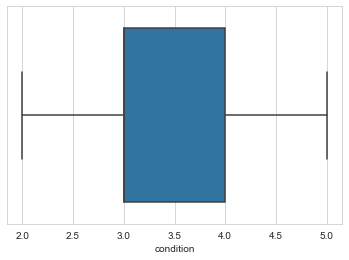

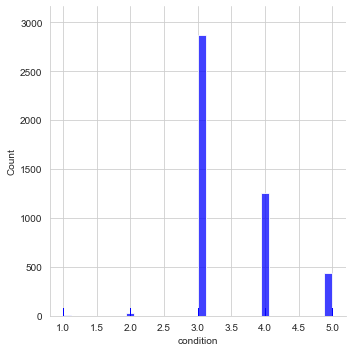

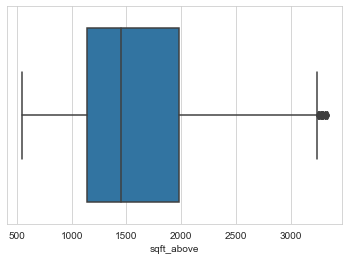

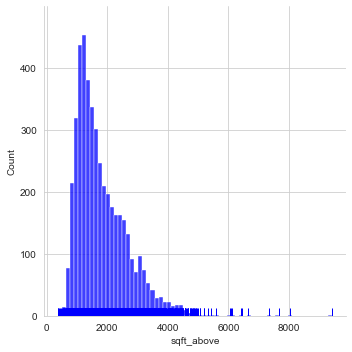

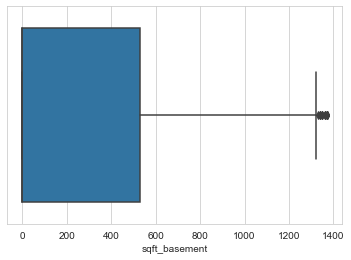

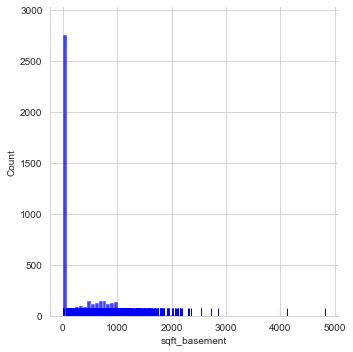

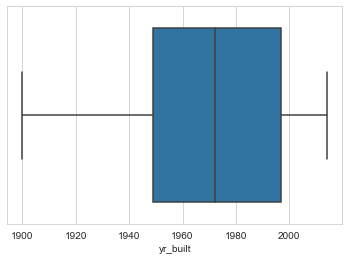

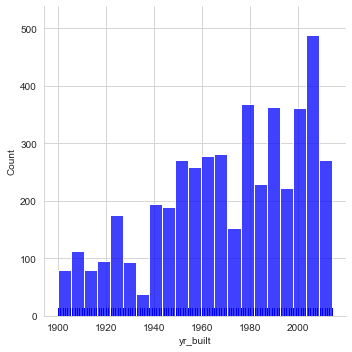

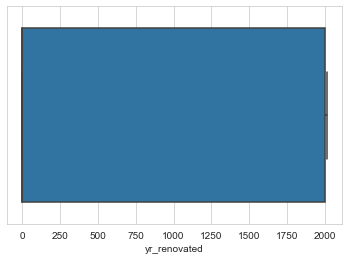

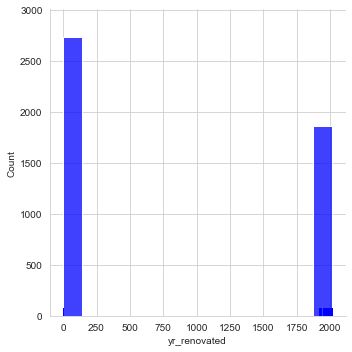

In [20]:
for column in hpp_numerical.columns:
    sns.boxplot(x=column,data=hpp_numerical)
    plt.show()
    
    sns.displot(hpp[column],color='Blue',rug=True)
    plt.show()

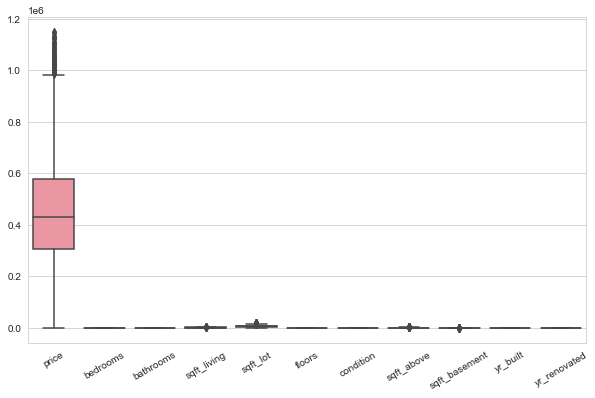

In [21]:
plt.subplots(figsize=(10, 6))
x = sns.boxplot(data=hpp_numerical)
x.set_xticklabels(x.get_xticklabels(), rotation=30);


In [22]:
hpp_a = hpp_numerical.drop('price',axis=1)

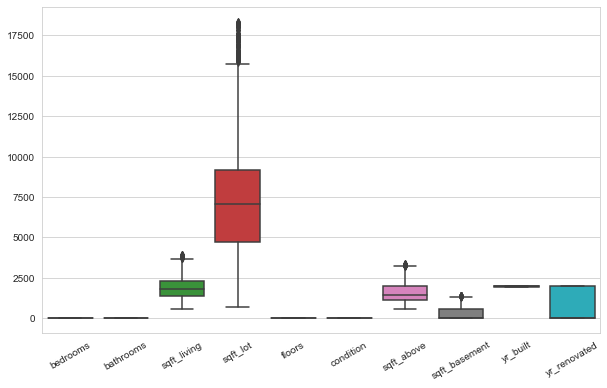

In [23]:
plt.subplots(figsize=(10, 6))
x = sns.boxplot(data=hpp_a)
x.set_xticklabels(x.get_xticklabels(), rotation=30);

In [24]:
"""
for column in hpp_numerical.columns:
    
    #using IQR
    iqr = np.percentile(hpp_numerical[column],75) - np.percentile(hpp_numerical[column],25)
    ll = np.percentile(hpp_numerical[column],25) - (1.5 * iqr)
    ul = np.percentile(hpp_numerical[column],75) + (1.5 * iqr)
    
    #using 3 STD Technique
    #ul = np.mean(hpp_numerical[column]) + (3*np.std(hpp_numerical[column]))
    #ll = np.mean(hpp_numerical[column]) - (3*np.std(hpp_numerical[column]))
    
    print(column)
    print(ll,ul)
    print(hpp_numerical[(hpp_numerical[column]>ul) | (hpp_numerical[column]<ll) ][column].count())
    #print(hpp_numerical[(hpp_numerical[column]>hpp_price_ul) | (hpp_numerical[column]<hpp_price_ll) ].index)
    
    
    hpp_numerical.drop(hpp_numerical[(hpp_numerical[column]>hpp_price_ul) | (hpp_numerical[column]<hpp_price_ll)].index,inplace=True)
    
    """

'\nfor column in hpp_numerical.columns:\n    \n    #using IQR\n    iqr = np.percentile(hpp_numerical[column],75) - np.percentile(hpp_numerical[column],25)\n    ll = np.percentile(hpp_numerical[column],25) - (1.5 * iqr)\n    ul = np.percentile(hpp_numerical[column],75) + (1.5 * iqr)\n    \n    #using 3 STD Technique\n    #ul = np.mean(hpp_numerical[column]) + (3*np.std(hpp_numerical[column]))\n    #ll = np.mean(hpp_numerical[column]) - (3*np.std(hpp_numerical[column]))\n    \n    print(column)\n    print(ll,ul)\n    print(hpp_numerical[(hpp_numerical[column]>ul) | (hpp_numerical[column]<ll) ][column].count())\n    #print(hpp_numerical[(hpp_numerical[column]>hpp_price_ul) | (hpp_numerical[column]<hpp_price_ll) ].index)\n    \n    \n    hpp_numerical.drop(hpp_numerical[(hpp_numerical[column]>hpp_price_ul) | (hpp_numerical[column]<hpp_price_ll)].index,inplace=True)\n    \n    '

In [25]:
hpp_numerical.shape

(3561, 11)

In [26]:
hpp_without_outliers = hpp.iloc[hpp_numerical.index]

In [27]:
#hpp_without_outliers.head()

In [28]:
hpp_without_outliers.shape

(3561, 18)

In [29]:
hpp_without_outliers['floors'].max()

3.5

In [30]:
#sns.factorplot(x='floors',y='price',data='hpp')

In [31]:
"""
fig, ax = pyplot.subplots(figsize=(9,7))
sns.lineplot(x="bedrooms", y="price",
             hue="month",
             data=hpp_without_outliers,ax=ax)
"""

'\nfig, ax = pyplot.subplots(figsize=(9,7))\nsns.lineplot(x="bedrooms", y="price",\n             hue="month",\n             data=hpp_without_outliers,ax=ax)\n'

In [32]:
hpp_without_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3561 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           3561 non-null   datetime64[ns]
 1   price          3561 non-null   float64       
 2   bedrooms       3561 non-null   float64       
 3   bathrooms      3561 non-null   float64       
 4   sqft_living    3561 non-null   int64         
 5   sqft_lot       3561 non-null   int64         
 6   floors         3561 non-null   float64       
 7   waterfront     3561 non-null   category      
 8   view           3561 non-null   category      
 9   condition      3561 non-null   int64         
 10  sqft_above     3561 non-null   int64         
 11  sqft_basement  3561 non-null   int64         
 12  yr_built       3561 non-null   int64         
 13  yr_renovated   3561 non-null   int64         
 14  street         3561 non-null   object        
 15  city           3561 n

In [33]:
"""
sns.catplot(
    data=hpp_without_outliers, kind="bar",
    x="month", y="price",hue='waterfront',
    ci="sd", palette="dark", alpha=.6, height=6
)
"""

'\nsns.catplot(\n    data=hpp_without_outliers, kind="bar",\n    x="month", y="price",hue=\'waterfront\',\n    ci="sd", palette="dark", alpha=.6, height=6\n)\n'

In [34]:
"""
sns.jointplot(
    data=hpp_without_outliers,
    x="bedrooms", y="floors", hue = 'month',
    kind="kde",
)
"""

'\nsns.jointplot(\n    data=hpp_without_outliers,\n    x="bedrooms", y="floors", hue = \'month\',\n    kind="kde",\n)\n'

In [35]:
hpp_without_outliers['statezip'].str[:2].nunique()

1

In [36]:
"""
sns.lmplot(
    data=hpp,
    x="sqft_above", y="price", hue="month",
    height=5
)
"""

'\nsns.lmplot(\n    data=hpp,\n    x="sqft_above", y="price", hue="month",\n    height=5\n)\n'

In [37]:
#fig = px.scatter_3d(hpp_without_outliers.iloc[:50], x='bedrooms', y='floors', z='bathrooms',color='view')
#fig.show()

In [38]:
hpp_final = hpp_without_outliers.drop(['date','street','statezip'],axis=1)

In [39]:
hpp_final.shape

(3561, 15)

In [40]:
hpp_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3561 entries, 0 to 4599
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   price          3561 non-null   float64 
 1   bedrooms       3561 non-null   float64 
 2   bathrooms      3561 non-null   float64 
 3   sqft_living    3561 non-null   int64   
 4   sqft_lot       3561 non-null   int64   
 5   floors         3561 non-null   float64 
 6   waterfront     3561 non-null   category
 7   view           3561 non-null   category
 8   condition      3561 non-null   int64   
 9   sqft_above     3561 non-null   int64   
 10  sqft_basement  3561 non-null   int64   
 11  yr_built       3561 non-null   int64   
 12  yr_renovated   3561 non-null   int64   
 13  city           3561 non-null   category
 14  month          3561 non-null   category
dtypes: category(4), float64(4), int64(7)
memory usage: 349.6 KB


## Predictive Analysis

In [41]:
#train, test = train_test_split(hpp_final, test_size=0.2, random_state=42)

In [42]:
hpp_final = pd.get_dummies(hpp_final, columns=['waterfront','view','city','month'])

In [43]:
hpp_final.shape

(3561, 65)

In [44]:
X = hpp_final.drop("price" , axis=1)   ####data_treatedFinal.drop("HR" , axis=1)
y = hpp_final.pop("price")             #####data_treatedFinal.pop("HR")

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.40, random_state=1) 

In [46]:
X_train.shape

(2136, 64)

In [47]:
from sklearn.preprocessing import StandardScaler
# Define the scaler 
scaler = StandardScaler()

# Scale the train set
X_train = scaler.fit_transform(X_train)

# Scale the test set
X_test = scaler.transform(X_test)

In [48]:
from sklearn.linear_model import LinearRegression
lnrModel = LinearRegression()                                    
lnrModel.fit(X_train, y_train)   

LinearRegression()

In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
pred = lnrModel.predict(X_test) 

In [50]:
# Mean Absolute Error
mean_absolute_error(y_test, pred)

2685067983528432.5

In [51]:
# RMSE
mean_squared_error(y_test, pred)**0.5

5.8954585720721544e+16

In [52]:
# R2 Squared:
r2_score(y_test, pred)

-8.32336458032244e+22